# Group 7
# ADS 504 Summer 2024

In [1]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

/var/folders/jw/4t4swxld5c5f_5xhv0_bzbr00000gn/T/ipykernel_89391/1681077365.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the data

file_path = "/Users/gabrielmancillas/Desktop/504-01/Final/nvda_2018.csv"

# file_path = "/workspaces/ADS-504-02-Group-7-Machine-Learning-and-Deep-Learning-for-Data-Science/nvda_2018.csv"
data = pd.read_csv(file_path)

## TEST. Ensure data shows for given file_path. Comment out ones not unique to you.

In [3]:
data.head()

time    open     high      low    close  PlotCandle (Open)  \
0  1510086600  5.2830  5.30175  5.28300  5.30025             5.2830   
1  1510151400  5.2950  5.29825  5.21275  5.23525             5.2950   
2  1510155000  5.2355  5.26125  5.23000  5.23675             5.2355   
3  1510158600  5.2360  5.24300  5.18225  5.21825             5.2360   
4  1510162200  5.2155  5.22200  5.18750  5.20150             5.2155   

   PlotCandle (High  PlotCandle (Low)  PlotCandle (Close)      VWAP  ...  \
0           5.30175           5.28300             5.30025  4.462440  ...   
1           5.29825           5.21275             5.23525  4.464509  ...   
2           5.26125           5.23000             5.23675  4.465430  ...   
3           5.24300           5.18225             5.21825  4.466655  ...   
4           5.22200           5.18750             5.20150  4.467462  ...   

   ImpulseMACDCDSignal        RSI  Regular Bullish  Regular Bullish Label  \
0             0.057289  69.475334              NaN                    NaN   
1             0.052901  51.395830              NaN                    NaN   
2             0.045753  51.708145              NaN                    NaN   
3             0.034023  47.642077              NaN                    NaN   
4             0.022199  44.249339              NaN                    NaN   

   Hidden Bullish  Hidden Bullish Label  Regular Bearish  \
0             NaN                   NaN              NaN   
1             NaN                   NaN              NaN   
2             NaN                   NaN              NaN   
3             NaN                   NaN              NaN   
4             NaN                   NaN              NaN   

   Regular Bearish Label  Hidden Bearish  Hidden Bearish Label  
0                    NaN             NaN                   NaN  
1                    NaN             NaN                   NaN  
2                    NaN             NaN                   NaN  
3                    NaN             NaN                   NaN  
4                    NaN             NaN                   NaN  

[5 rows x 29 columns]

## Feature engineering.
### Convert original UNIX 'time' to datetime object

In [4]:
# Convert UNIX time to datetime object
data["time"] = pd.to_datetime(data["time"], unit="s")

### Add feature. Day of the week.

In [5]:
# Feature Engineering. Day of the week.
data["day_of_week"] = data["time"].dt.day_name()
data.insert(1, "day_of_week", data.pop("day_of_week"))

### Convert from UTC time to America/New_York time (where NYSE trades)

In [6]:
# Convert to New York time (Where NYSE trades)
data["time"] = data["time"].dt.tz_localize("GMT")
data["time"] = data["time"].dt.tz_convert("America/New_York")

### Add feature. Morning / Afternoon categories.

In [7]:
# Feature Engineering. Morning/Afternoon
data["session"] = data["time"].dt.hour.apply(
    lambda x: "Morning" if x < 12 else "Afternoon"
)
data.insert(2, "session", data.pop("session"))

### Add feature. Target = closing price = opening price

In [8]:
# Feature Engineering
data["target"] = data["close"] - data["open"]

### Add feature. Target_t+1 to be used as "forecasted" value. Use as model evaluation metric using RMSE. Penalize larger errors greater.

In [9]:
data["target_t+1"] = data["target"].shift(-1)

### Checkpoint. Post-Feature Engineering.

In [10]:
data.head()

time day_of_week    session    open     high      low  \
0 2017-11-07 15:30:00-05:00     Tuesday  Afternoon  5.2830  5.30175  5.28300   
1 2017-11-08 09:30:00-05:00   Wednesday    Morning  5.2950  5.29825  5.21275   
2 2017-11-08 10:30:00-05:00   Wednesday    Morning  5.2355  5.26125  5.23000   
3 2017-11-08 11:30:00-05:00   Wednesday    Morning  5.2360  5.24300  5.18225   
4 2017-11-08 12:30:00-05:00   Wednesday  Afternoon  5.2155  5.22200  5.18750   

     close  PlotCandle (Open)  PlotCandle (High  PlotCandle (Low)  ...  \
0  5.30025             5.2830           5.30175           5.28300  ...   
1  5.23525             5.2950           5.29825           5.21275  ...   
2  5.23675             5.2355           5.26125           5.23000  ...   
3  5.21825             5.2360           5.24300           5.18225  ...   
4  5.20150             5.2155           5.22200           5.18750  ...   

   Regular Bullish  Regular Bullish Label  Hidden Bullish  \
0              NaN                    NaN             NaN   
1              NaN                    NaN             NaN   
2              NaN                    NaN             NaN   
3              NaN                    NaN             NaN   
4              NaN                    NaN             NaN   

   Hidden Bullish Label  Regular Bearish  Regular Bearish Label  \
0                   NaN              NaN                    NaN   
1                   NaN              NaN                    NaN   
2                   NaN              NaN                    NaN   
3                   NaN              NaN                    NaN   
4                   NaN              NaN                    NaN   

   Hidden Bearish  Hidden Bearish Label   target  target_t+1  
0             NaN                   NaN  0.01725    -0.05975  
1             NaN                   NaN -0.05975     0.00125  
2             NaN                   NaN  0.00125    -0.01775  
3             NaN                   NaN -0.01775    -0.01400  
4             NaN                   NaN -0.01400     0.00950  

[5 rows x 33 columns]

In [11]:
# Ensure the 'time' column is timezone-naive (if needed)
data["time"] = data["time"].dt.tz_localize(None)

# Remove rows where 'time' is between January 1, 2024, and December 31, 2024
data = data[(data["time"] < "2024-01-01") | (data["time"] > "2024-12-31")]

# Optionally, you can check the first few rows to confirm the dates have been removed
print(data.head())
print(data.tail())

                 time day_of_week    session    open     high      low  \
0 2017-11-07 15:30:00     Tuesday  Afternoon  5.2830  5.30175  5.28300   
1 2017-11-08 09:30:00   Wednesday    Morning  5.2950  5.29825  5.21275   
2 2017-11-08 10:30:00   Wednesday    Morning  5.2355  5.26125  5.23000   
3 2017-11-08 11:30:00   Wednesday    Morning  5.2360  5.24300  5.18225   
4 2017-11-08 12:30:00   Wednesday  Afternoon  5.2155  5.22200  5.18750   

     close  PlotCandle (Open)  PlotCandle (High  PlotCandle (Low)  ...  \
0  5.30025             5.2830           5.30175           5.28300  ...   
1  5.23525             5.2950           5.29825           5.21275  ...   
2  5.23675             5.2355           5.26125           5.23000  ...   
3  5.21825             5.2360           5.24300           5.18225  ...   
4  5.20150             5.2155           5.22200           5.18750  ...   

   Regular Bullish  Regular Bullish Label  Hidden Bullish  \
0              NaN                    NaN        

In [12]:
import plotly.express as px

# Alternatively, using boolean indexing
# data = data[(data['time'] < '2024-01-01') | (data['time'] > '2024-12-31')]

# Now, you can visualize the data or continue with other analyses
fig = px.line(data, x="time", y="close", title="Close Price History without 2024")
fig.update_traces(line_color="blue")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis_tickprefix="$",
    yaxis_tickformat=".2f",
)
fig.show()

# now save the remove 2024 data for the rest to the report
data.to_csv("nvda_2018_no_2024.csv", index=False)

# Load the data
data = pd.read_csv("nvda_2018_no_2024.csv")

## EDA

### Explore cardinality and remove null or columns with no variation (1 or 0 cardinality)

In [13]:
cardinality = data.nunique()

# Remove columns with 1 or 0 cardinality
col_keep = cardinality[cardinality > 1].index
data = data[col_keep]
data.nunique()

time                     10781
day_of_week                  5
session                      2
open                      9774
high                      9607
low                       9646
close                     9657
PlotCandle (Open)         9774
PlotCandle (High          9607
PlotCandle (Low)          9646
PlotCandle (Close)        9657
VWAP                     10781
Upper Band #1            10781
Lower Band #1            10781
Upper Band #2            10781
Lower Band #2            10781
Upper Band #3            10781
Lower Band #3            10781
ImpulseMACD               8697
ImpulseHisto              9401
ImpulseMACDCDSignal       9366
RSI                      10766
Regular Bullish            706
Regular Bullish Label       43
Hidden Bullish             706
Regular Bearish            716
Regular Bearish Label       99
Hidden Bearish             716
target                    4159
target_t+1                4160
dtype: int64

## EDA. Visualization.

### Price

<Axes: >

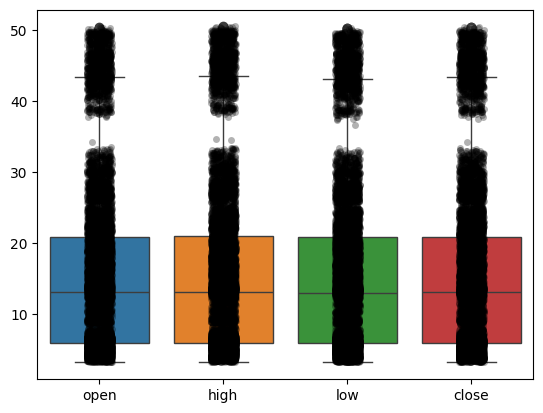

In [14]:
sns.boxplot(data=data[["open", "high", "low", "close"]])
sns.stripplot(
    data=data[["open", "high", "low", "close"]], jitter=True, color="black", alpha=0.3
)

Many outliers present in price. Should handle with appropriate method (clipping) to minimize affect on standard deviation and mean.

### Regular Bullish/Bearish Value Distribution

Text(0.5, 1.0, 'Regular Bullish vs Regular Bearish')

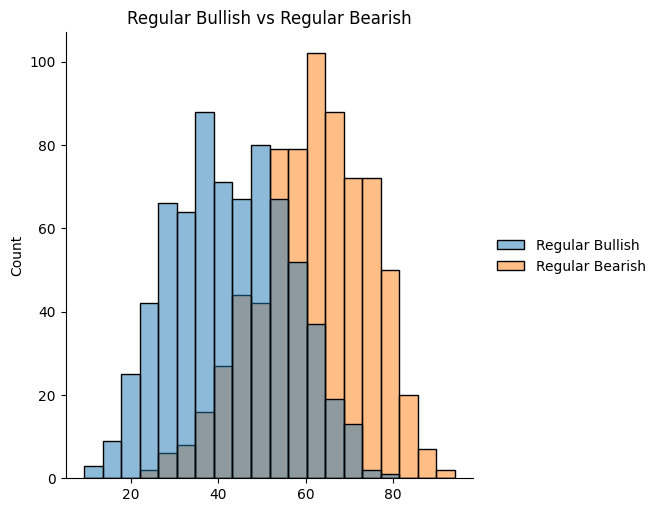

In [15]:
df = pd.DataFrame(data)
sns.displot(df[["Regular Bullish", "Regular Bearish"]])
plt.title("Regular Bullish vs Regular Bearish")

## Data Cleaning. Handle outliers with clipping.

In [16]:
num_cols = data.select_dtypes(include=[np.number])

Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

num_cols_clipped = num_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)
data = num_cols_clipped.join(data.drop(columns=num_cols.columns))

## Checkpoint. Post-Data Cleaning: Clipped.



In [17]:
data.head()

open     high      low    close  PlotCandle (Open)  PlotCandle (High  \
0  5.2830  5.30175  5.28300  5.30025             5.2830           5.30175   
1  5.2950  5.29825  5.21275  5.23525             5.2950           5.29825   
2  5.2355  5.26125  5.23000  5.23675             5.2355           5.26125   
3  5.2360  5.24300  5.18225  5.21825             5.2360           5.24300   
4  5.2155  5.22200  5.18750  5.20150             5.2155           5.22200   

   PlotCandle (Low)  PlotCandle (Close)      VWAP  Upper Band #1  ...  \
0           5.28300             5.30025  4.462440       4.817839  ...   
1           5.21275             5.23525  4.464509       4.821719  ...   
2           5.23000             5.23675  4.465430       4.823430  ...   
3           5.18225             5.21825  4.466655       4.825640  ...   
4           5.18750             5.20150  4.467462       4.827079  ...   

   Regular Bullish Label  Hidden Bullish  Regular Bearish  \
0                    NaN             NaN              NaN   
1                    NaN             NaN              NaN   
2                    NaN             NaN              NaN   
3                    NaN             NaN              NaN   
4                    NaN             NaN              NaN   

   Regular Bearish Label  Hidden Bearish   target  target_t+1  \
0                    NaN             NaN  0.01725    -0.05975   
1                    NaN             NaN -0.05975     0.00125   
2                    NaN             NaN  0.00125    -0.01775   
3                    NaN             NaN -0.01775    -0.01400   
4                    NaN             NaN -0.01400     0.00950   

                  time  day_of_week    session  
0  2017-11-07 15:30:00      Tuesday  Afternoon  
1  2017-11-08 09:30:00    Wednesday    Morning  
2  2017-11-08 10:30:00    Wednesday    Morning  
3  2017-11-08 11:30:00    Wednesday    Morning  
4  2017-11-08 12:30:00    Wednesday  Afternoon  

[5 rows x 30 columns]

### Plot boxplots of outlier-handled data

<Axes: >

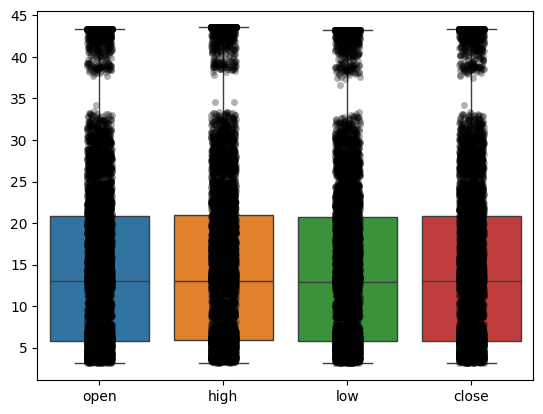

In [18]:
sns.boxplot(data=data[["open", "high", "low", "close"]])
sns.stripplot(
    data=data[["open", "high", "low", "close"]], jitter=True, color="black", alpha=0.3
)

In [19]:
data.describe()

open          high           low         close  \
count  10781.000000  10781.000000  10781.000000  10781.000000   
mean      15.300710     15.390753     15.204052     15.299776   
std       11.664361     11.721758     11.594155     11.659471   
min        3.141750      3.150750      3.113500      3.141250   
25%        5.868500      5.900500      5.825000      5.872250   
50%       13.019250     13.097250     12.943750     13.018250   
75%       20.883000     20.958000     20.768000     20.871000   
max       43.404750     43.544250     43.182500     43.369125   

       PlotCandle (Open)  PlotCandle (High  PlotCandle (Low)  \
count       10781.000000      10781.000000      10781.000000   
mean           15.300710         15.390753         15.204052   
std            11.664361         11.721758         11.594155   
min             3.141750          3.150750          3.113500   
25%             5.868500          5.900500          5.825000   
50%            13.019250         13.097250         12.943750   
75%            20.883000         20.958000         20.768000   
max            43.404750         43.544250         43.182500   

       PlotCandle (Close)          VWAP  Upper Band #1  ...  \
count        10781.000000  10781.000000   10781.000000  ...   
mean            15.299776     15.204505      16.066543  ...   
std             11.659471     11.839504      12.459957  ...   
min              3.141250      3.631566       3.809856  ...   
25%              5.872250      5.860560       6.135456  ...   
50%             13.018250     13.067171      13.480595  ...   
75%             20.871000     21.545674      22.508145  ...   
max             43.369125     45.073346      47.067180  ...   

       ImpulseMACDCDSignal           RSI  Regular Bullish  \
count         10781.000000  10781.000000       706.000000   
mean              0.033252     52.404662        42.731837   
std               0.191618     13.925539        13.205528   
min              -0.308316     12.124692         9.412335   
25%              -0.050028     42.409297        32.929200   
50%               0.002001     52.848979        42.282505   
75%               0.122164     62.599033        52.387105   
max               0.380452     92.883637        77.615040   

       Regular Bullish Label  Hidden Bullish  Regular Bearish  \
count              43.000000      706.000000       716.000000   
mean               31.418698       42.731837        61.837151   
std                 5.731709       13.205528        12.540207   
min                18.297603        9.412335        27.214031   
25%                27.514567       32.929200        53.546798   
50%                31.747788       42.282505        62.499069   
75%                35.775531       52.387105        71.101976   
max                43.499904       77.615040        94.098040   

       Regular Bearish Label  Hidden Bearish        target    target_t+1  
count              99.000000      716.000000  10781.000000  10781.000000  
mean               69.414834       61.837151      0.001671      0.001653  
std                 6.502911       12.540207      0.093998      0.094014  
min                52.846857       27.214031     -0.177625     -0.177625  
25%                65.225056       53.546798     -0.043000     -0.043000  
50%                69.047959       62.499069      0.001000      0.001000  
75%                73.477188       71.101976      0.046750      0.046750  
max                85.855387       94.098040      0.181375      0.181375  

[8 rows x 27 columns]

## Data Cleaning. Handle missing values.

In [20]:
# Use forward fill as it is logical for previous known value to carry forward
data.fillna(method="ffill", inplace=True)

/var/folders/jw/4t4swxld5c5f_5xhv0_bzbr00000gn/T/ipykernel_89391/3449298444.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [21]:
# Correct column names
correct_column_names = [
    "time",
    "day_of_week",
    "session",
    "open",
    "high",
    "low",
    "close",
    "PlotCandle (Open)",
    "PlotCandle (High)",
    "PlotCandle (Low)",
    "PlotCandle (Close)",
    "VWAP",
    "Upper Band #1",
    "Lower Band #1",
    "Upper Band #2",
    "Lower Band #2",
    "Upper Band #3",
    "Lower Band #3",
    "MidLine",
    "ImpulseMACD",
    "ImpulseHisto",
    "ImpulseMACDSignal",
    "RSI",
    "Regular Bullish Label",
    "Regular Bullish",
    "Hidden Bullish Label",
    "Hidden Bullish",
    "Regular Bearish Label",
    "Regular Bearish",
    "Hidden Bearish Label",
    "Hidden Bearish",
]

In [22]:
# Lag Features
for lag in range(1, 4):
    data[f"close_lag_{lag}"] = data["close"].shift(lag)

# Rolling Statistics
data["close_rolling_mean_5"] = data["close"].rolling(window=5).mean()
data["close_rolling_std_5"] = data["close"].rolling(window=5).std()

In [23]:
data.columns

Index(['open', 'high', 'low', 'close', 'PlotCandle (Open)', 'PlotCandle (High',
       'PlotCandle (Low)', 'PlotCandle (Close)', 'VWAP', 'Upper Band #1',
       'Lower Band #1', 'Upper Band #2', 'Lower Band #2', 'Upper Band #3',
       'Lower Band #3', 'ImpulseMACD', 'ImpulseHisto', 'ImpulseMACDCDSignal',
       'RSI', 'Regular Bullish', 'Regular Bullish Label', 'Hidden Bullish',
       'Regular Bearish', 'Regular Bearish Label', 'Hidden Bearish', 'target',
       'target_t+1', 'time', 'day_of_week', 'session', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'close_rolling_mean_5',
       'close_rolling_std_5'],
      dtype='object')

In [24]:
# Drop unused columns
columns_to_drop = [
    "Regular Bullish",
    "Regular Bullish Label",
    "Hidden Bullish",
    "Regular Bearish",
    "Regular Bearish Label",
    "Hidden Bearish",
]
data.drop(columns=columns_to_drop, inplace=True)

# Convert categorical features to numerical
data = pd.get_dummies(data, columns=["day_of_week", "session"], drop_first=True)

# Create the target variable: close - open
data["target"] = data["close"] - data["open"]
data["target_t+1"] = data["target"].shift(-1)

# Handle NaN introduced by the shift
data.dropna(subset=["target_t+1"], inplace=True)

# Extract features and target variable
X = data.drop(columns=["time", "close", "target", "target_t+1"])
y = data["target_t+1"]

In [25]:
from sklearn.impute import SimpleImputer

# Ensure alignment of X and y
X = X.iloc[:-1]
y = y.iloc[:-1]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# show me the updated data
data.head()

open     high      low    close  PlotCandle (Open)  PlotCandle (High  \
0  5.2830  5.30175  5.28300  5.30025             5.2830           5.30175   
1  5.2950  5.29825  5.21275  5.23525             5.2950           5.29825   
2  5.2355  5.26125  5.23000  5.23675             5.2355           5.26125   
3  5.2360  5.24300  5.18225  5.21825             5.2360           5.24300   
4  5.2155  5.22200  5.18750  5.20150             5.2155           5.22200   

   PlotCandle (Low)  PlotCandle (Close)      VWAP  Upper Band #1  ...  \
0           5.28300             5.30025  4.462440       4.817839  ...   
1           5.21275             5.23525  4.464509       4.821719  ...   
2           5.23000             5.23675  4.465430       4.823430  ...   
3           5.18225             5.21825  4.466655       4.825640  ...   
4           5.18750             5.20150  4.467462       4.827079  ...   

   close_lag_1  close_lag_2  close_lag_3  close_rolling_mean_5  \
0          NaN          NaN          NaN                   NaN   
1      5.30025          NaN          NaN                   NaN   
2      5.23525      5.30025          NaN                   NaN   
3      5.23675      5.23525      5.30025                   NaN   
4      5.21825      5.23675      5.23525                5.2384   

   close_rolling_std_5  day_of_week_Monday  day_of_week_Thursday  \
0                  NaN               False                 False   
1                  NaN               False                 False   
2                  NaN               False                 False   
3                  NaN               False                 False   
4             0.037436               False                 False   

   day_of_week_Tuesday  day_of_week_Wednesday  session_Morning  
0                 True                  False            False  
1                False                   True             True  
2                False                   True             True  
3                False                   True             True  
4                False                   True            False  

[5 rows x 32 columns]

In [27]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_grid_xgb, n_iter=10, cv=3, scoring="r2", n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Conv1D,
    Flatten,
    GRU,
    Input,
    MultiHeadAttention,
    LayerNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# Assuming X_train_scaled, X_test_scaled, y_train, y_test, and random_search_xgb are already defined

# Initialize models
lr_model = LinearRegression()
best_rf_model = RandomForestRegressor(random_state=42)
best_xgb_model = xgb.XGBRegressor(**random_search_xgb.best_params_)

# Train models
lr_model.fit(X_train_scaled, y_train)
best_rf_model.fit(X_train_scaled, y_train)
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate models
lr_predictions = lr_model.predict(X_test_scaled)
rf_predictions = best_rf_model.predict(X_test_scaled)
xgb_predictions = best_xgb_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)


# FFNN Model
def create_ffnn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Create and train the FFNN model
ffnn_model = create_ffnn_model()
ffnn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the FFNN model
ffnn_predictions = ffnn_model.predict(X_test_scaled)
ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_r2 = r2_score(y_test, ffnn_predictions)


# LSTM Model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(1, X_train_scaled.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_reshaped = X_test_scaled.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# Create and train the LSTM model
lstm_model = create_lstm_model()
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)


# CNN Model
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=2, activation="relu"))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Reshape input to be [samples, features, channels]
X_train_cnn_reshaped = X_train_scaled.reshape(
    (X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
)
X_test_cnn_reshaped = X_test_scaled.reshape(
    (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
)

# Create and train the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_cnn_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn_reshaped)
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)


# GRU Model
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(1, X_train_scaled.shape[1])))
    model.add(GRU(50, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Create and train the GRU model
gru_model = create_gru_model()
gru_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the GRU model
gru_predictions = gru_model.predict(X_test_reshaped)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_r2 = r2_score(y_test, gru_predictions)


# Transformer Model
def create_transformer_model():
    inputs = Input(shape=(1, X_train_scaled.shape[1]))
    attention = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    attention = LayerNormalization(epsilon=1e-6)(attention)
    attention = Flatten()(attention)
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss="mse", metrics=["mae"])
    return model


# Create and train the Transformer model
transformer_model = create_transformer_model()
transformer_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the Transformer model
transformer_predictions = transformer_model.predict(X_test_reshaped)
transformer_predictions = transformer_predictions.reshape(-1, 1)  # Reshape to 2D array
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_r2 = r2_score(y_test, transformer_predictions)

print(f"Linear Regression MSE: {lr_mse}, R2: {lr_r2}")
print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")
print(f"Best XGBoost Parameters: {random_search_xgb.best_params_}")
print(f"FFNN MSE: {ffnn_mse}, R2: {ffnn_r2}")
print(f"LSTM MSE: {lstm_mse}, R2: {lstm_r2}")
print(f"CNN MSE: {cnn_mse}, R2: {cnn_r2}")
print(f"GRU MSE: {gru_mse}, R2: {gru_r2}")
print(f"Transformer MSE: {transformer_mse}, R2: {transformer_r2}")

# Cross-Validation Scores
cv_scores_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1
)
print(f"XGBoost 5-fold CV R2: {np.mean(cv_scores_xgb)}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning:

You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning:

You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



Linear Regression MSE: 0.022464653334456897, R2: -0.005944823603211358
Random Forest MSE: 0.024062242102332133, R2: -0.07748325900055342
XGBoost MSE: 0.022331805877502588, R2: 3.95333371394635e-06
Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
FFNN MSE: 0.03340136011481857, R2: -0.49567967101775934
LSTM MSE: 0.027087308848047064, R2: -0.21294273788058704
CNN MSE: 0.022624075635046353, R2: -0.013083595595695163
GRU MSE: 0.025755860520522655, R2: -0.15332180658787142
Transformer MSE: 0.02278699073240538, R2: -0.020378771552127972
XGBoost 5-fold CV R2: 0.00043991281636144295


In [29]:
import pandas as pd

# Define model names and their respective MSE and R-squared values
models = [
    "Linear Regression",
    "Random Forest",
    "XGBoost",
    "FFNN",
    "LSTM",
    "CNN",
    "GRU",
    "Transformer",
]
mse_values = [
    lr_mse,
    rf_mse,
    xgb_mse,
    ffnn_mse,
    lstm_mse,
    cnn_mse,
    gru_mse,
    transformer_mse,
]
r2_values = [lr_r2, rf_r2, xgb_r2, ffnn_r2, lstm_r2, cnn_r2, gru_r2, transformer_r2]

# Create a DataFrame to store the results
results_df = pd.DataFrame({"Model": models, "MSE": mse_values, "R-squared": r2_values})

# Print the results table
print(results_df)

               Model       MSE  R-squared
0  Linear Regression  0.022465  -0.005945
1      Random Forest  0.024062  -0.077483
2            XGBoost  0.022332   0.000004
3               FFNN  0.033401  -0.495680
4               LSTM  0.027087  -0.212943
5                CNN  0.022624  -0.013084
6                GRU  0.025756  -0.153322
7        Transformer  0.022787  -0.020379


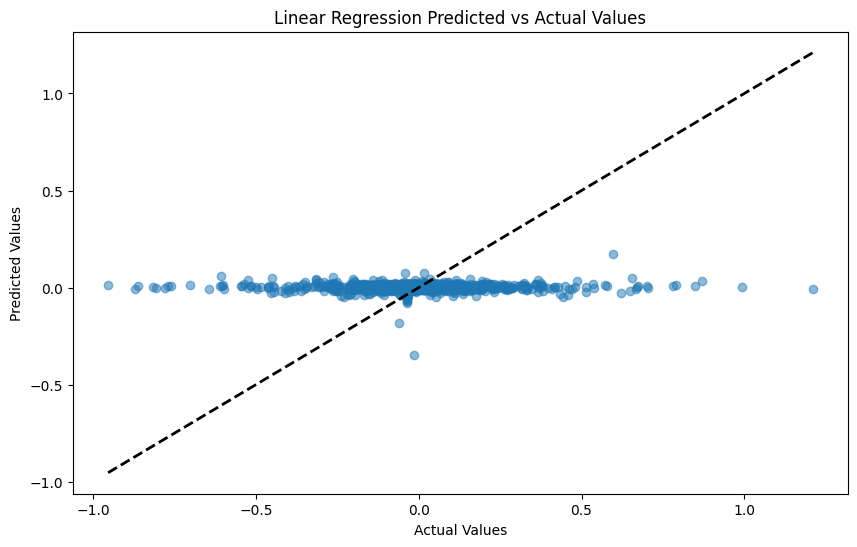

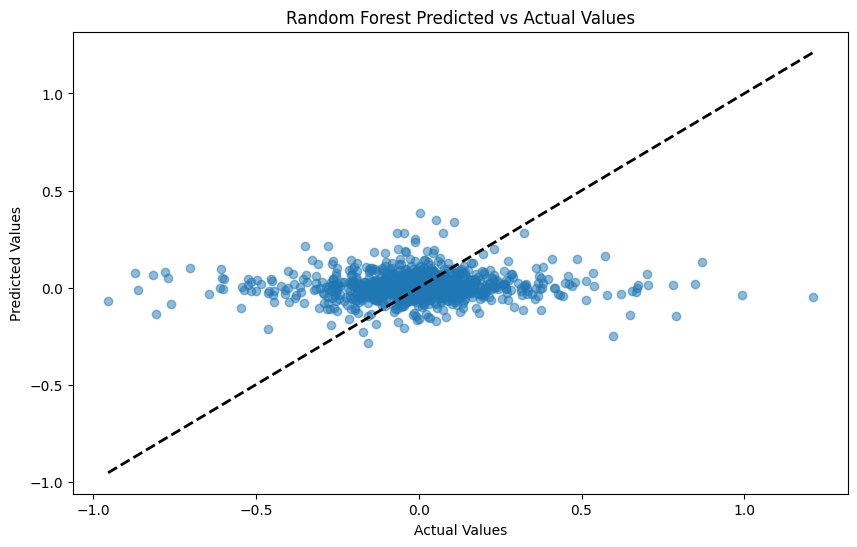

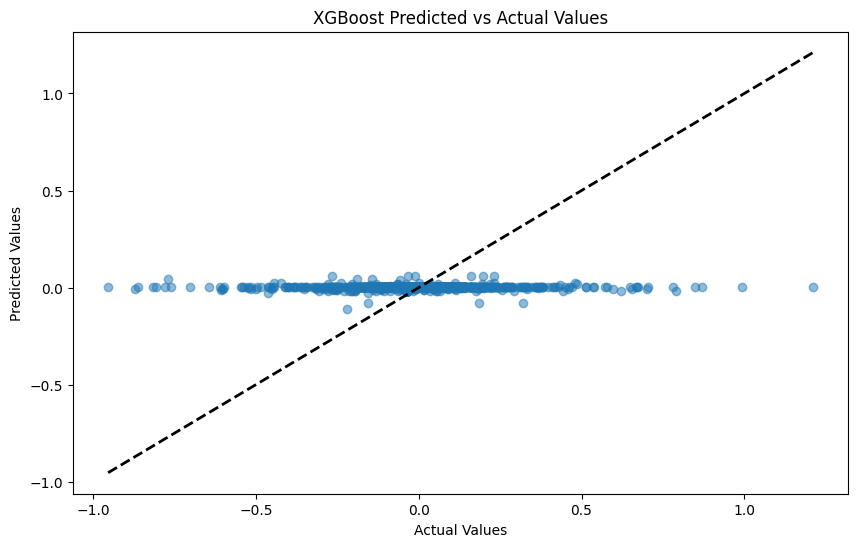

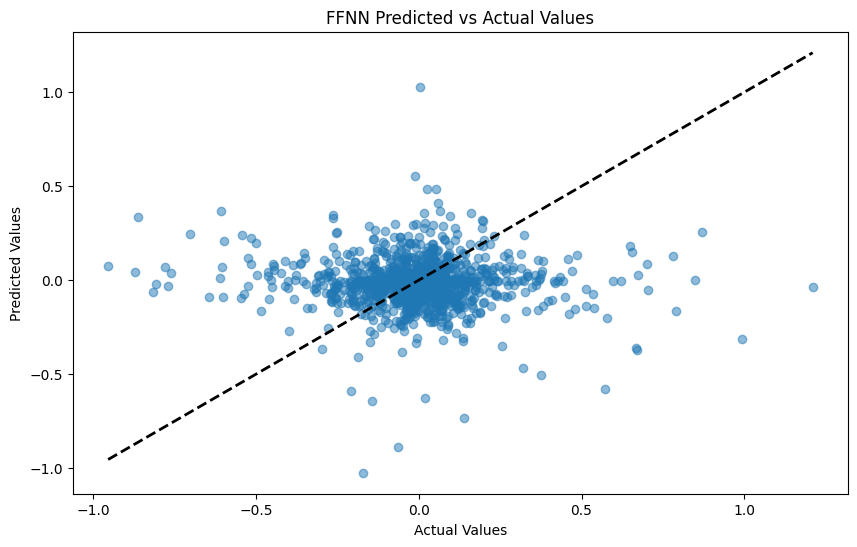

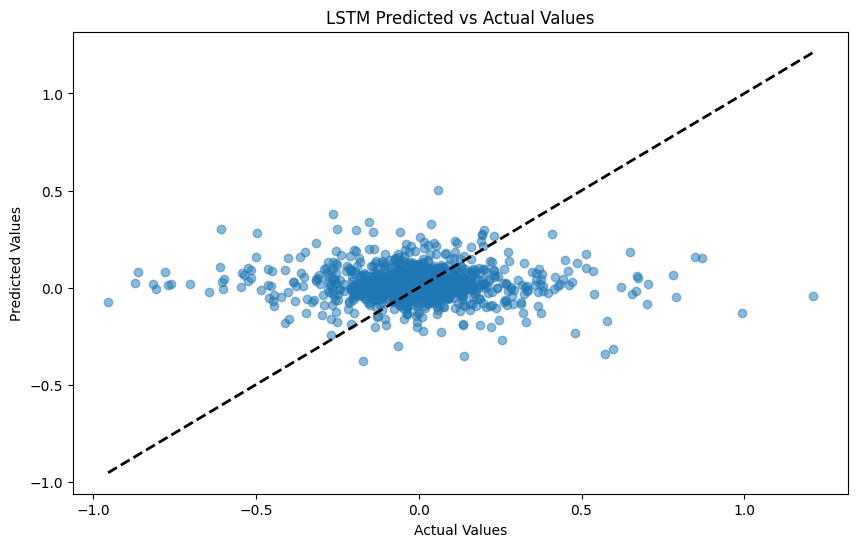

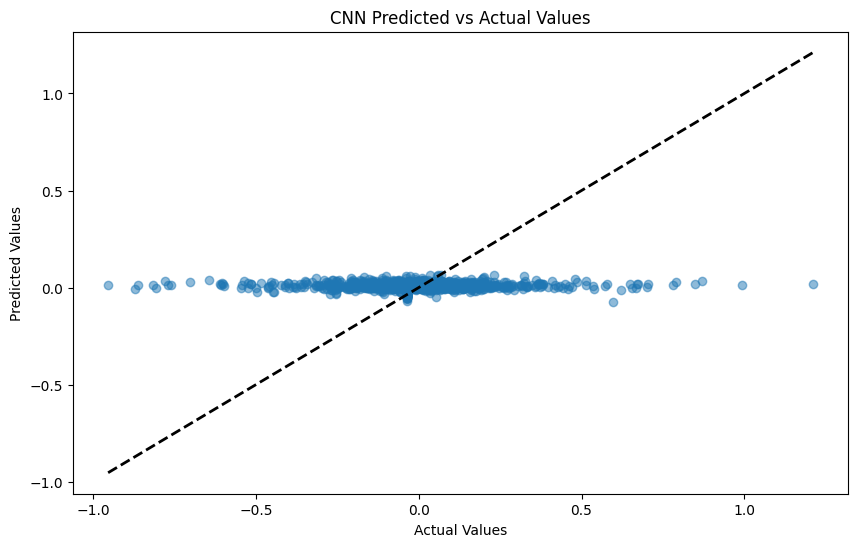

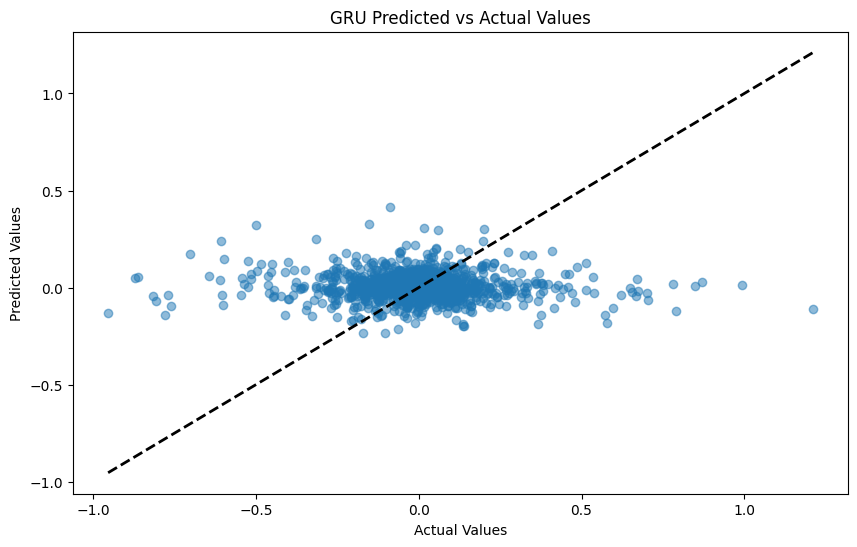

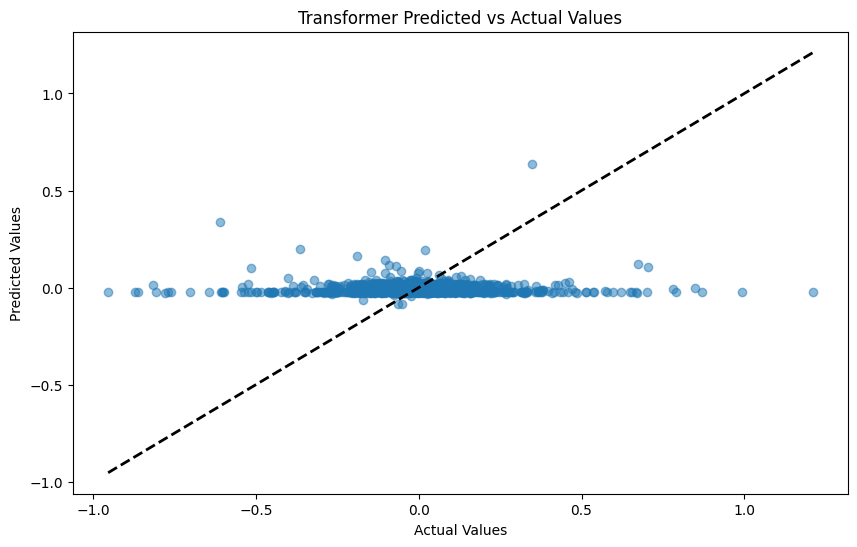

In [30]:
# Scatter Plots of predicted vs. actual values

import matplotlib.pyplot as plt


# Function to plot predicted vs actual values
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "k--", lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} Predicted vs Actual Values")
    plt.show()


# Plot predictions for each model
plot_predictions(y_test, lr_predictions, "Linear Regression")
plot_predictions(y_test, rf_predictions, "Random Forest")
plot_predictions(y_test, xgb_predictions, "XGBoost")
plot_predictions(y_test, ffnn_predictions, "FFNN")
plot_predictions(y_test, lstm_predictions, "LSTM")
plot_predictions(y_test, cnn_predictions, "CNN")
plot_predictions(y_test, gru_predictions, "GRU")
plot_predictions(y_test, transformer_predictions, "Transformer")

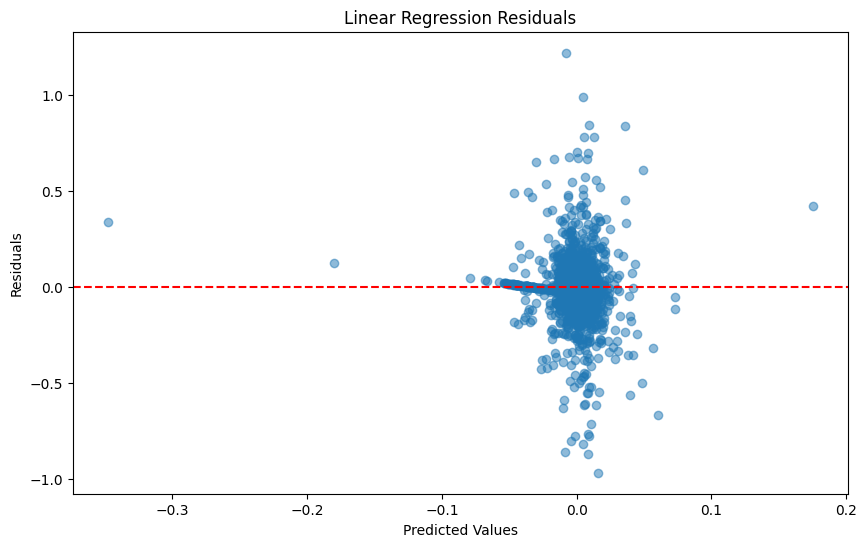

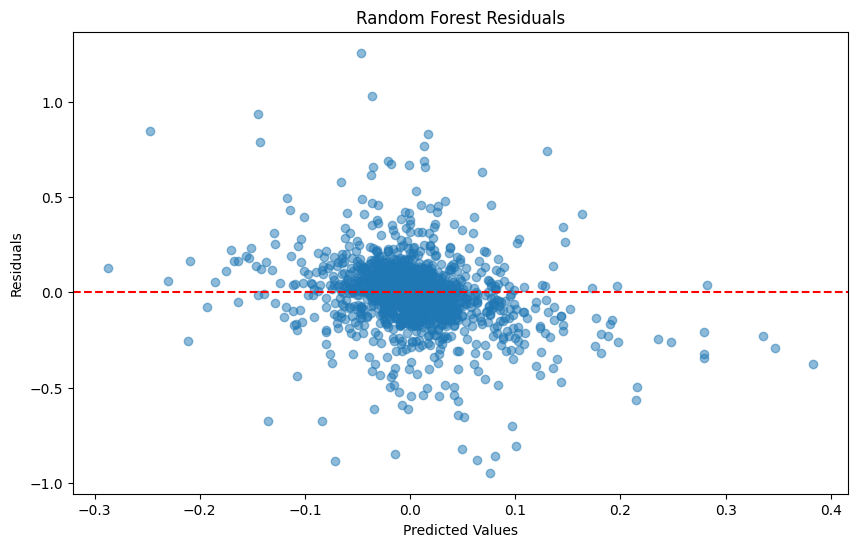

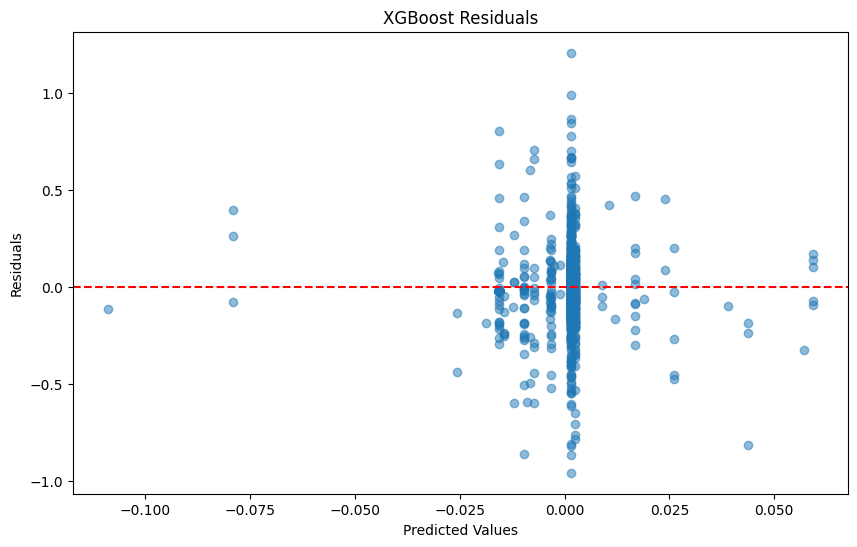

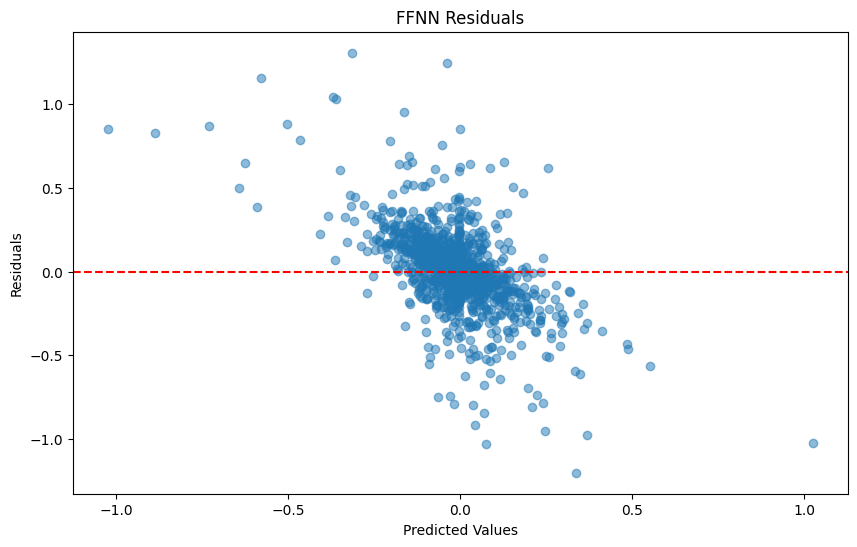

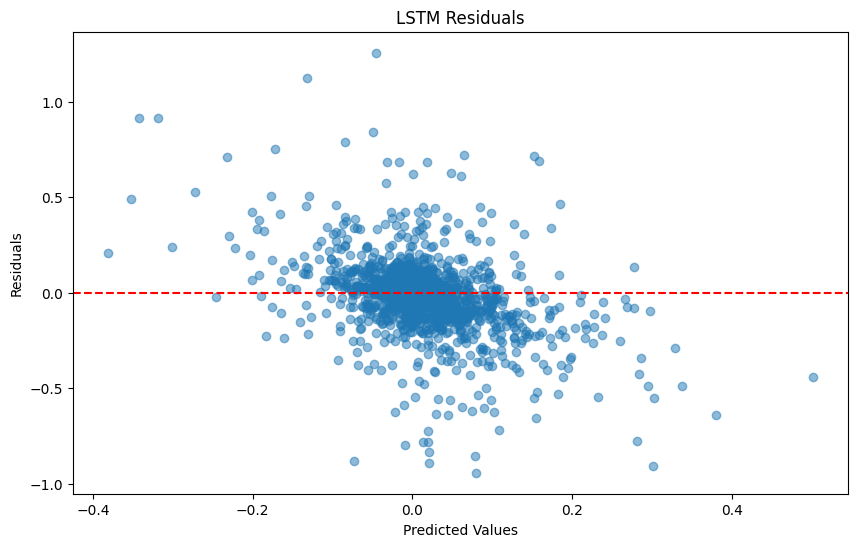

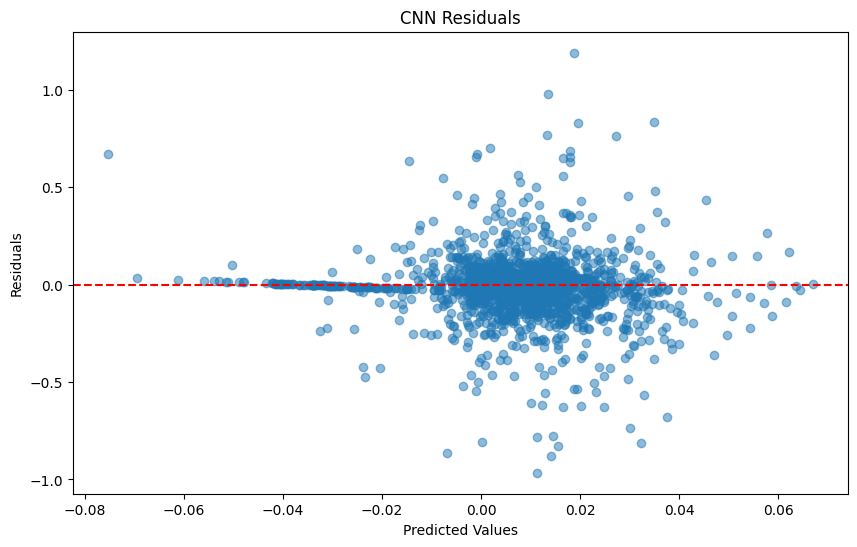

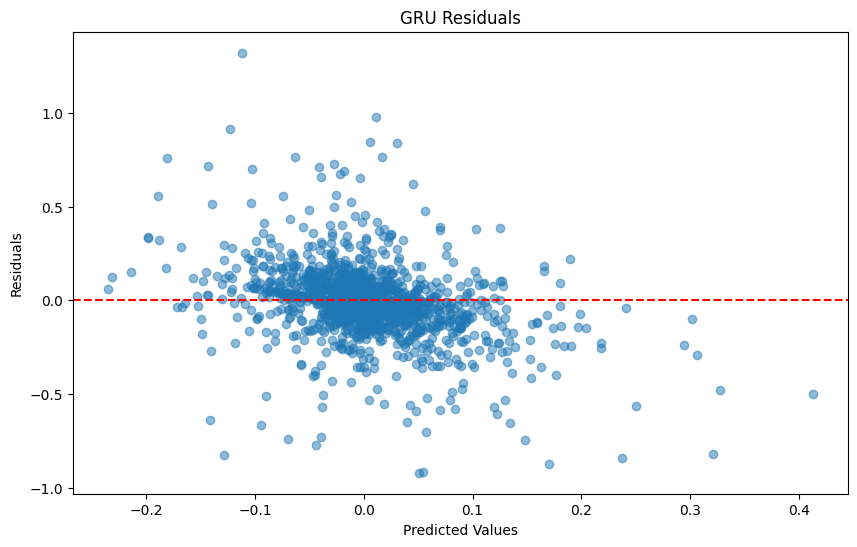

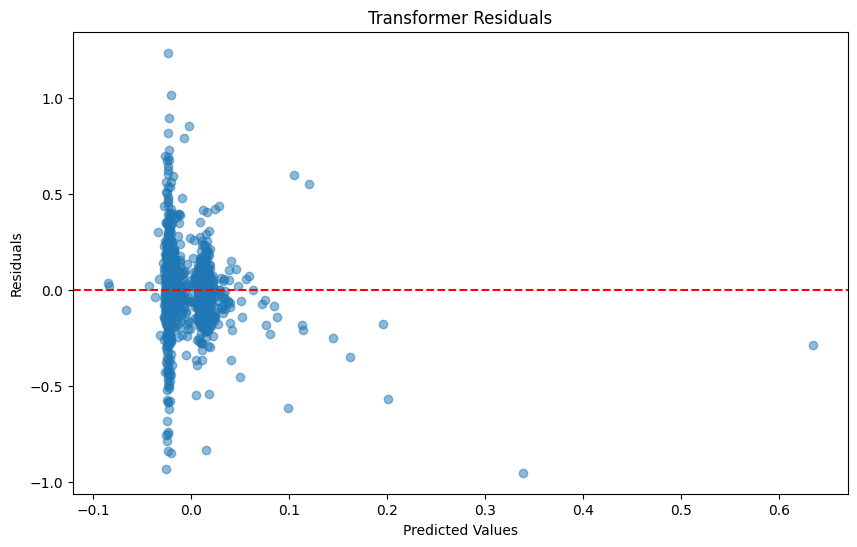

In [31]:
# Residual Plots to analyze the errors (residuals).

import matplotlib.pyplot as plt


# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} Residuals")
    plt.show()


# Plot residuals for each model
plot_residuals(y_test, lr_predictions, "Linear Regression")
plot_residuals(y_test, rf_predictions, "Random Forest")
plot_residuals(y_test, xgb_predictions, "XGBoost")
plot_residuals(y_test, ffnn_predictions.flatten(), "FFNN")
plot_residuals(y_test, lstm_predictions.flatten(), "LSTM")
plot_residuals(y_test, cnn_predictions.flatten(), "CNN")
plot_residuals(y_test, gru_predictions.flatten(), "GRU")
plot_residuals(y_test, transformer_predictions.flatten(), "Transformer")

/var/folders/jw/4t4swxld5c5f_5xhv0_bzbr00000gn/T/ipykernel_89391/2244925589.py:51: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/jw/4t4swxld5c5f_5xhv0_bzbr00000gn/T/ipykernel_89391/2244925589.py:57: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/jw/4t4swxld5c5f_5xhv0_bzbr00000gn/T/ipykernel_89391/2244925589.py:63: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



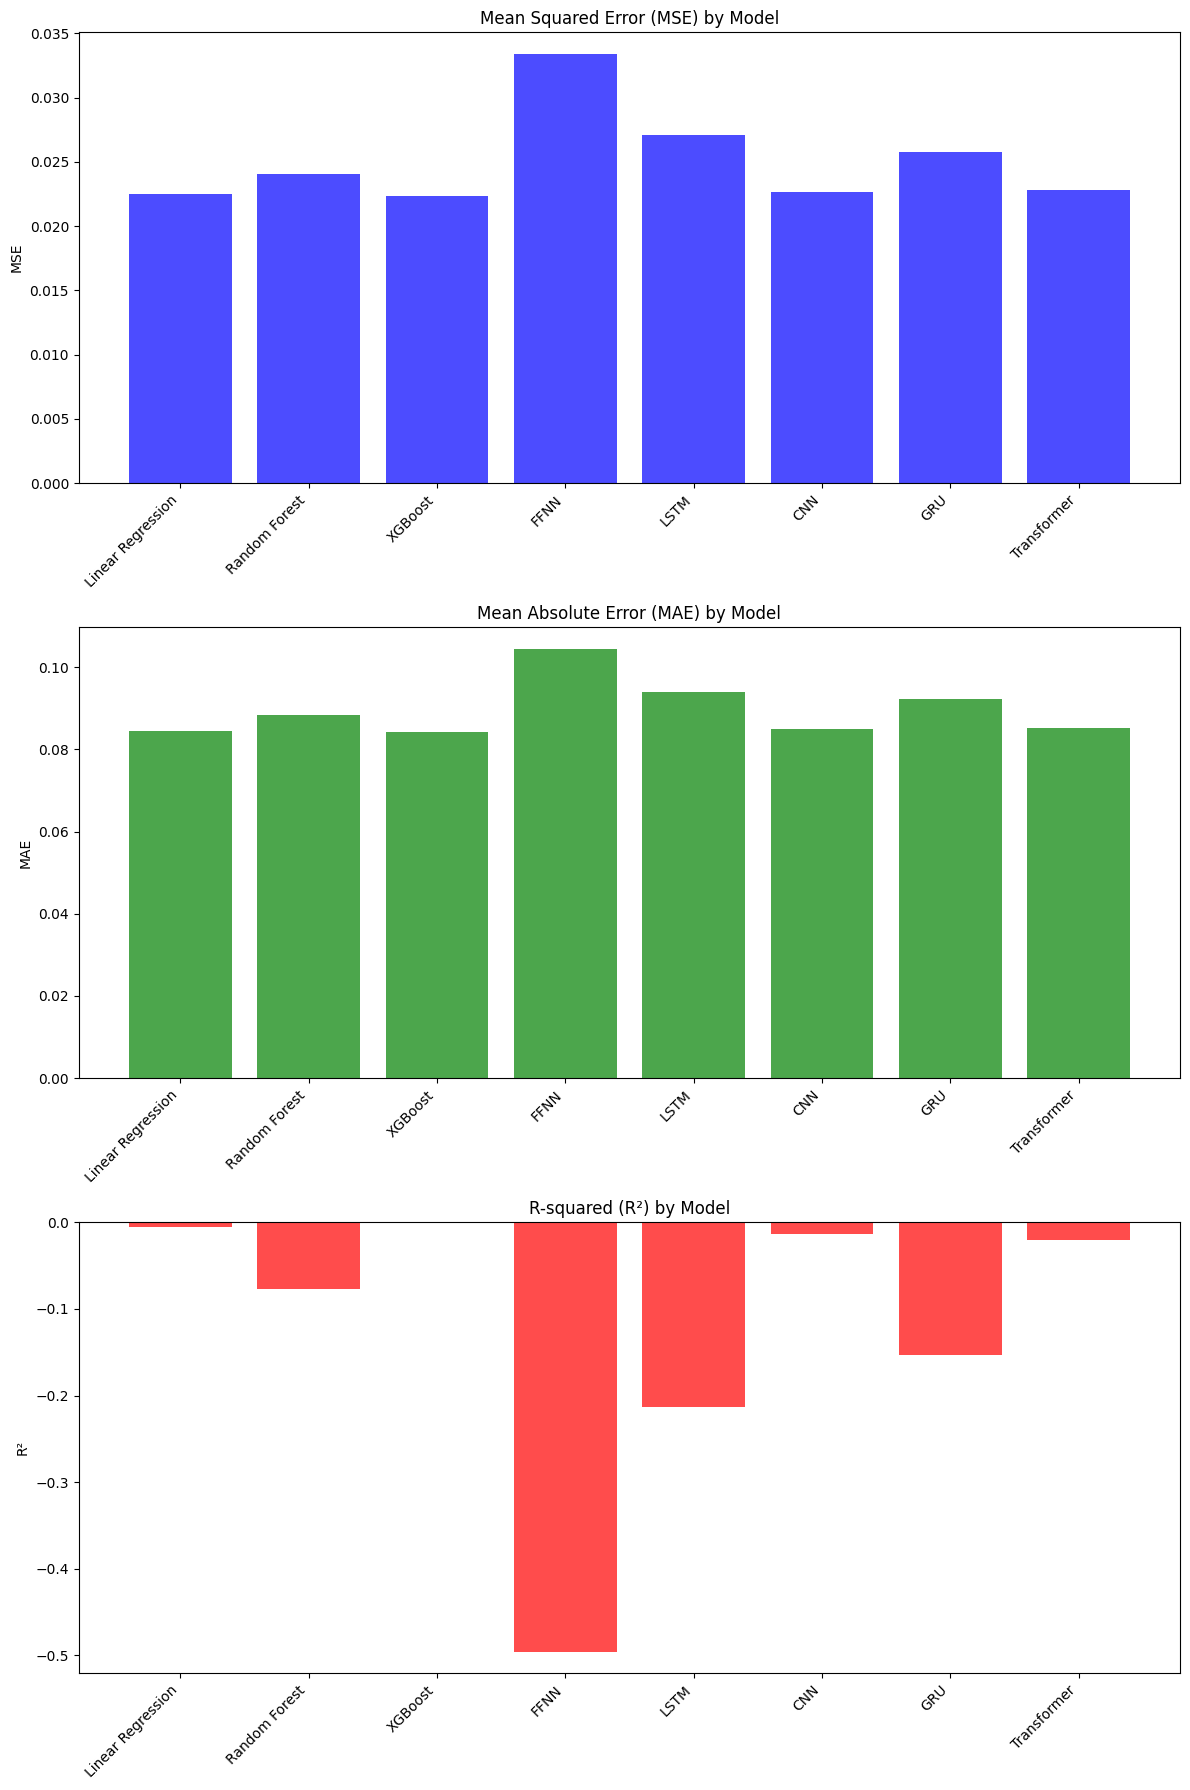

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate performance metrics
metrics = {
    "Model": [
        "Linear Regression",
        "Random Forest",
        "XGBoost",
        "FFNN",
        "LSTM",
        "CNN",
        "GRU",
        "Transformer",
    ],
    "MSE": [
        mean_squared_error(y_test, lr_predictions),
        mean_squared_error(y_test, rf_predictions),
        mean_squared_error(y_test, xgb_predictions),
        mean_squared_error(y_test, ffnn_predictions.flatten()),
        mean_squared_error(y_test, lstm_predictions.flatten()),
        mean_squared_error(y_test, cnn_predictions.flatten()),
        mean_squared_error(y_test, gru_predictions.flatten()),
        mean_squared_error(y_test, transformer_predictions.flatten()),
    ],
    "MAE": [
        mean_absolute_error(y_test, lr_predictions),
        mean_absolute_error(y_test, rf_predictions),
        mean_absolute_error(y_test, xgb_predictions),
        mean_absolute_error(y_test, ffnn_predictions.flatten()),
        mean_absolute_error(y_test, lstm_predictions.flatten()),
        mean_absolute_error(y_test, cnn_predictions.flatten()),
        mean_absolute_error(y_test, gru_predictions.flatten()),
        mean_absolute_error(y_test, transformer_predictions.flatten()),
    ],
    "R²": [
        r2_score(y_test, lr_predictions),
        r2_score(y_test, rf_predictions),
        r2_score(y_test, xgb_predictions),
        r2_score(y_test, ffnn_predictions.flatten()),
        r2_score(y_test, lstm_predictions.flatten()),
        r2_score(y_test, cnn_predictions.flatten()),
        r2_score(y_test, gru_predictions.flatten()),
        r2_score(y_test, transformer_predictions.flatten()),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot performance metrics
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot MSE
ax[0].bar(metrics_df["Model"], metrics_df["MSE"], color="b", alpha=0.7)
ax[0].set_title("Mean Squared Error (MSE) by Model")
ax[0].set_ylabel("MSE")
ax[0].set_xticklabels(metrics_df["Model"], rotation=45, ha="right")

# Plot MAE
ax[1].bar(metrics_df["Model"], metrics_df["MAE"], color="g", alpha=0.7)
ax[1].set_title("Mean Absolute Error (MAE) by Model")
ax[1].set_ylabel("MAE")
ax[1].set_xticklabels(metrics_df["Model"], rotation=45, ha="right")

# Plot R²
ax[2].bar(metrics_df["Model"], metrics_df["R²"], color="r", alpha=0.7)
ax[2].set_title("R-squared (R²) by Model")
ax[2].set_ylabel("R²")
ax[2].set_xticklabels(metrics_df["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [33]:
# Cross-Validation Scores for our models

from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming X_train_scaled and y_train are your training features and labels

# Linear Regression Cross-Validation
cv_r2_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring="r2")
cv_mse_lr = cross_val_score(
    lr_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error"
)
cv_mae_lr = cross_val_score(
    lr_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error"
)

print("Linear Regression Cross-Validation:")
print(f"R²: Mean = {np.mean(cv_r2_lr):.4f}, Std = {np.std(cv_r2_lr):.4f}")
print(f"MSE: Mean = {-np.mean(cv_mse_lr):.4f}, Std = {np.std(cv_mse_lr):.4f}")
print(f"MAE: Mean = {-np.mean(cv_mae_lr):.4f}, Std = {np.std(cv_mae_lr):.4f}")

Linear Regression Cross-Validation:
R²: Mean = -0.0084, Std = 0.0070
MSE: Mean = 0.0242, Std = 0.0019
MAE: Mean = 0.0850, Std = 0.0031


In [34]:
from sklearn.model_selection import cross_val_score

# Random Forest Cross-Validation with parallel processing
cv_r2_rf = cross_val_score(
    best_rf_model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1
)
cv_mse_rf = cross_val_score(
    best_rf_model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
cv_mae_rf = cross_val_score(
    best_rf_model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

print("Random Forest Cross-Validation:")
print(f"R²: Mean = {np.mean(cv_r2_rf):.4f}, Std = {np.std(cv_r2_rf):.4f}")
print(f"MSE: Mean = {-np.mean(cv_mse_rf):.4f}, Std = {np.std(cv_mse_rf):.4f}")
print(f"MAE: Mean = {-np.mean(cv_mae_rf):.4f}, Std = {np.std(cv_mae_rf):.4f}")

Random Forest Cross-Validation:
R²: Mean = -0.1232, Std = 0.0416
MSE: Mean = 0.0269, Std = 0.0022
MAE: Mean = 0.0904, Std = 0.0033


In [35]:
# XGBoost Cross-Validation
cv_r2_xgb = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=5, scoring="r2")
cv_mse_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error"
)
cv_mae_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error"
)

print("XGBoost Cross-Validation:")
print(f"R²: Mean = {np.mean(cv_r2_xgb):.4f}, Std = {np.std(cv_r2_xgb):.4f}")
print(f"MSE: Mean = {-np.mean(cv_mse_xgb):.4f}, Std = {np.std(cv_mse_xgb):.4f}")
print(f"MAE: Mean = {-np.mean(cv_mae_xgb):.4f}, Std = {np.std(cv_mae_xgb):.4f}")

XGBoost Cross-Validation:
R²: Mean = 0.0004, Std = 0.0038
MSE: Mean = 0.0240, Std = 0.0019
MAE: Mean = 0.0848, Std = 0.0032


In [36]:
import plotly.express as px

# Visualizing the history data
fig = px.line(data, x="time", y="PlotCandle (Close)", title="Close Price History")
fig.update_traces(line_color="blue")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis_tickprefix="$",
    yaxis_tickformat=",.2f",
    title_x=0.5,
)
fig.show()

In [37]:
print(data[["time", "close"]].tail(50))  # Check the last 50 entries

                      time      close
10730  2023-12-19 14:30:00  43.369125
10731  2023-12-19 15:30:00  43.369125
10732  2023-12-20 09:30:00  43.369125
10733  2023-12-20 10:30:00  43.369125
10734  2023-12-20 11:30:00  43.369125
10735  2023-12-20 12:30:00  43.369125
10736  2023-12-20 13:30:00  43.369125
10737  2023-12-20 14:30:00  43.369125
10738  2023-12-20 15:30:00  43.369125
10739  2023-12-21 09:30:00  43.369125
10740  2023-12-21 10:30:00  43.369125
10741  2023-12-21 11:30:00  43.369125
10742  2023-12-21 12:30:00  43.369125
10743  2023-12-21 13:30:00  43.369125
10744  2023-12-21 14:30:00  43.369125
10745  2023-12-21 15:30:00  43.369125
10746  2023-12-22 09:30:00  43.369125
10747  2023-12-22 10:30:00  43.369125
10748  2023-12-22 11:30:00  43.369125
10749  2023-12-22 12:30:00  43.369125
10750  2023-12-22 13:30:00  43.369125
10751  2023-12-22 14:30:00  43.369125
10752  2023-12-22 15:30:00  43.369125
10753  2023-12-26 09:30:00  43.369125
10754  2023-12-26 10:30:00  43.369125
10755  2023-

In [38]:
df.drop(
    df.columns.difference(["time", "close", "open", "high", "low"]),
    axis=1,
    inplace=True,
)
# show me the updated data
df.head()

time    open     high      low    close
0  2017-11-07 15:30:00  5.2830  5.30175  5.28300  5.30025
1  2017-11-08 09:30:00  5.2950  5.29825  5.21275  5.23525
2  2017-11-08 10:30:00  5.2355  5.26125  5.23000  5.23675
3  2017-11-08 11:30:00  5.2360  5.24300  5.18225  5.21825
4  2017-11-08 12:30:00  5.2155  5.22200  5.18750  5.20150

In [39]:
df.isnull().sum().sum()

0

In [45]:
fig = px.line(y=df.close, x=df.time)
fig.update_traces(line_color="black")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Scaled Price",
    title={
        "text": "Gold Price History Data",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    plot_bgcolor="rgba(255,223,0,0.8)",
    font=dict(family="Courier New, monospace", size=12, color="black"),
)

In [47]:
df["time"] = pd.to_datetime(df["time"])
test_size = df[df.time.dt.year == 2023].shape[0]

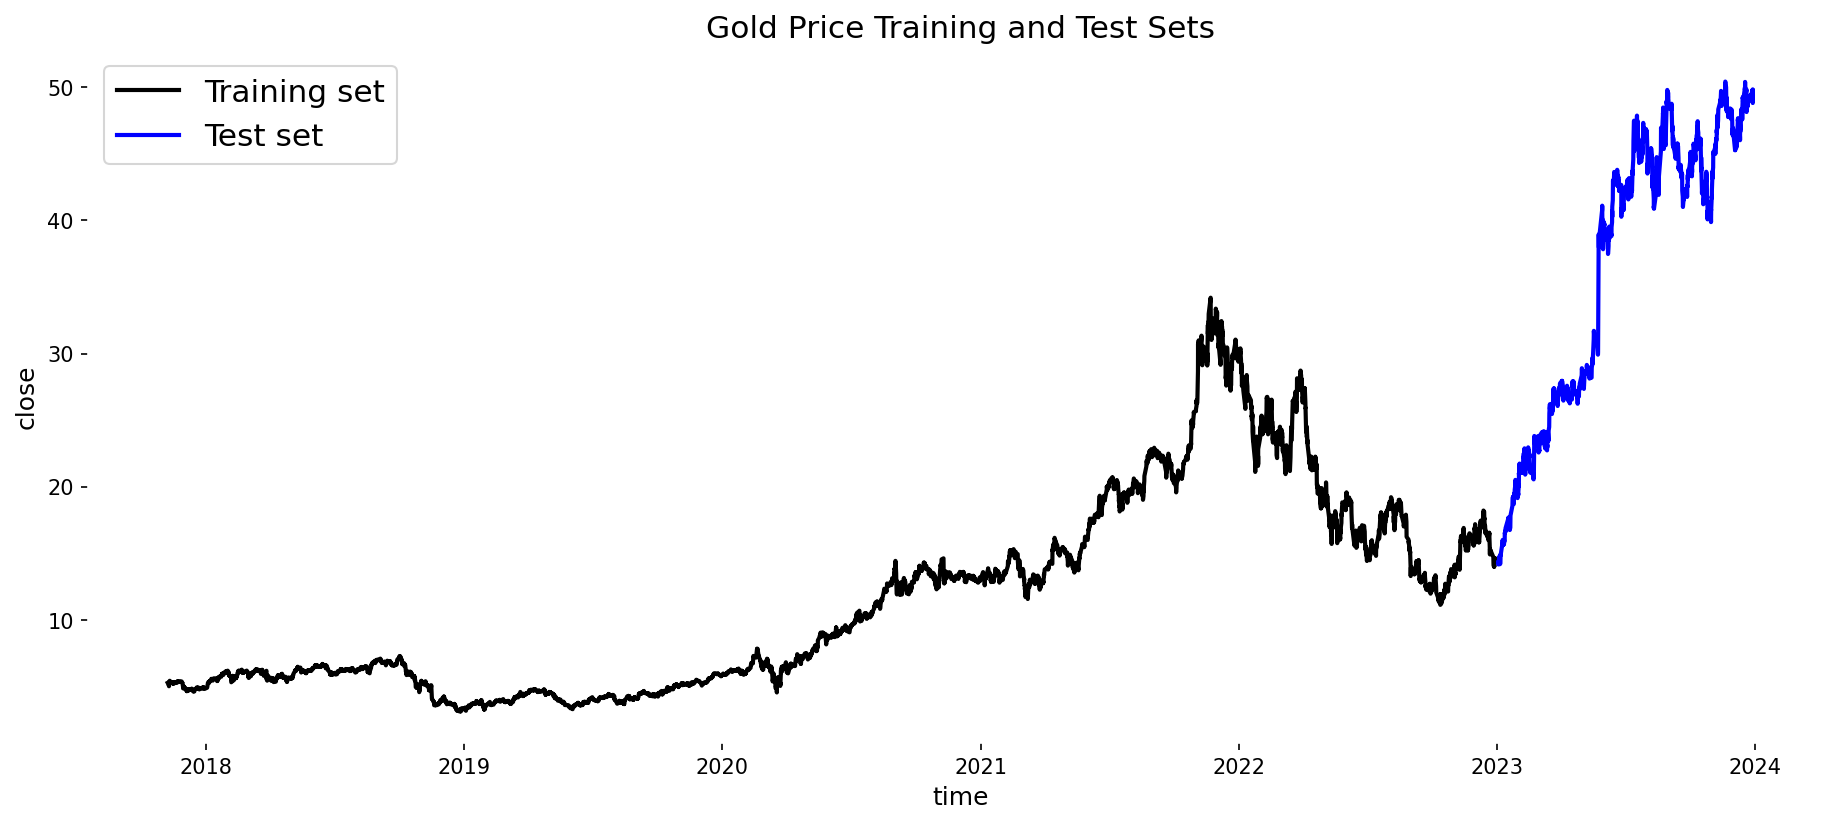

In [69]:
# Set the figure size and DPI
plt.figure(figsize=(15, 6), dpi=150)

# Customize the axes face color and edge color
plt.rcParams["axes.facecolor"] = "white"
plt.rc("axes", edgecolor="white")

# Plot the training set
plt.plot(
    df.time[:-test_size],
    df.close[:-test_size],
    color="black",
    lw=2,
    label="Training set",
)

# Plot the test set
plt.plot(
    df.time[-test_size:], df.close[-test_size:], color="blue", lw=2, label="Test set"
)

# Add title and labels with specified font sizes
plt.title("Gold Price Training and Test Sets", fontsize=15)
plt.xlabel("time", fontsize=12)
plt.ylabel("close", fontsize=12)

# Add a legend with a specified location and font size
plt.legend(loc="upper left", prop={"size": 15})

# Customize the grid color
plt.grid(color="white")

# Display the plot
plt.show()

In [52]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Apply log transformation to the data
X_train_log = np.log1p(X_train)  # np.log1p is log(1 + x) to avoid log(0) issues
X_test_log = np.log1p(X_test)

# After applying log transformation, you can then scale the data using one of the above methods
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

In [54]:
# restructure data and Create Sliding Windows

window_size = 60

train_data = df.close[:-test_size].values.reshape(-1, 1)

# Fit the scaler to the correct shape of the data
scaler.fit(train_data)

train_data = scaler.transform(train_data)

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])

In [56]:
# test data
test_data = df.close[-test_size - 60 :]
test_data = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])
    y_test.append(test_data[i, 0])

In [57]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [58]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape:  ", X_test.shape)
print("y_test Shape:  ", y_test.shape)

X_train Shape:  (8977, 60, 1)
y_train Shape:  (8977, 1)
X_test Shape:   (1744, 60, 1)
y_test Shape:   (1744, 1)


In [62]:
from keras.layers import Dropout


def define_model():
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=128, return_sequences=True)(input1)
    x = Dropout(0.3)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss="mean_squared_error", optimizer="Nadam")
    model.summary()

    return model


model = define_model()
history = model.fit(
    X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,889 (1.27 MB)

 Trainable params: 333,889 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - loss: 0.0104 - val_loss: 4.4413e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 0.0010 - val_loss: 8.2926e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 8.5954e-04 - val_loss: 4.7826e-04
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - loss: 7.3351e-04 - val_loss: 5.8802e-04
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 6.9695e-04 - val_loss: 3.1124e-04
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 5.3384e-04 - val_loss: 8.8348e-04
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 5.9164e-04 - val_loss: 4.0200e-04
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 4.9145e-04 - val_loss: 2.5756e-04
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 4.9872e-04 - val_loss: 2.9240e-04
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 4.6608e-04 - val_loss: 2.4783e-04
Epoch 11/100
127/127 ━━━━━━

In [63]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0049
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [65]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [66]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.015274085104465485
Test MAPE: 0.07588539690968123
Test Accuracy: 0.9241146030903188


In [67]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

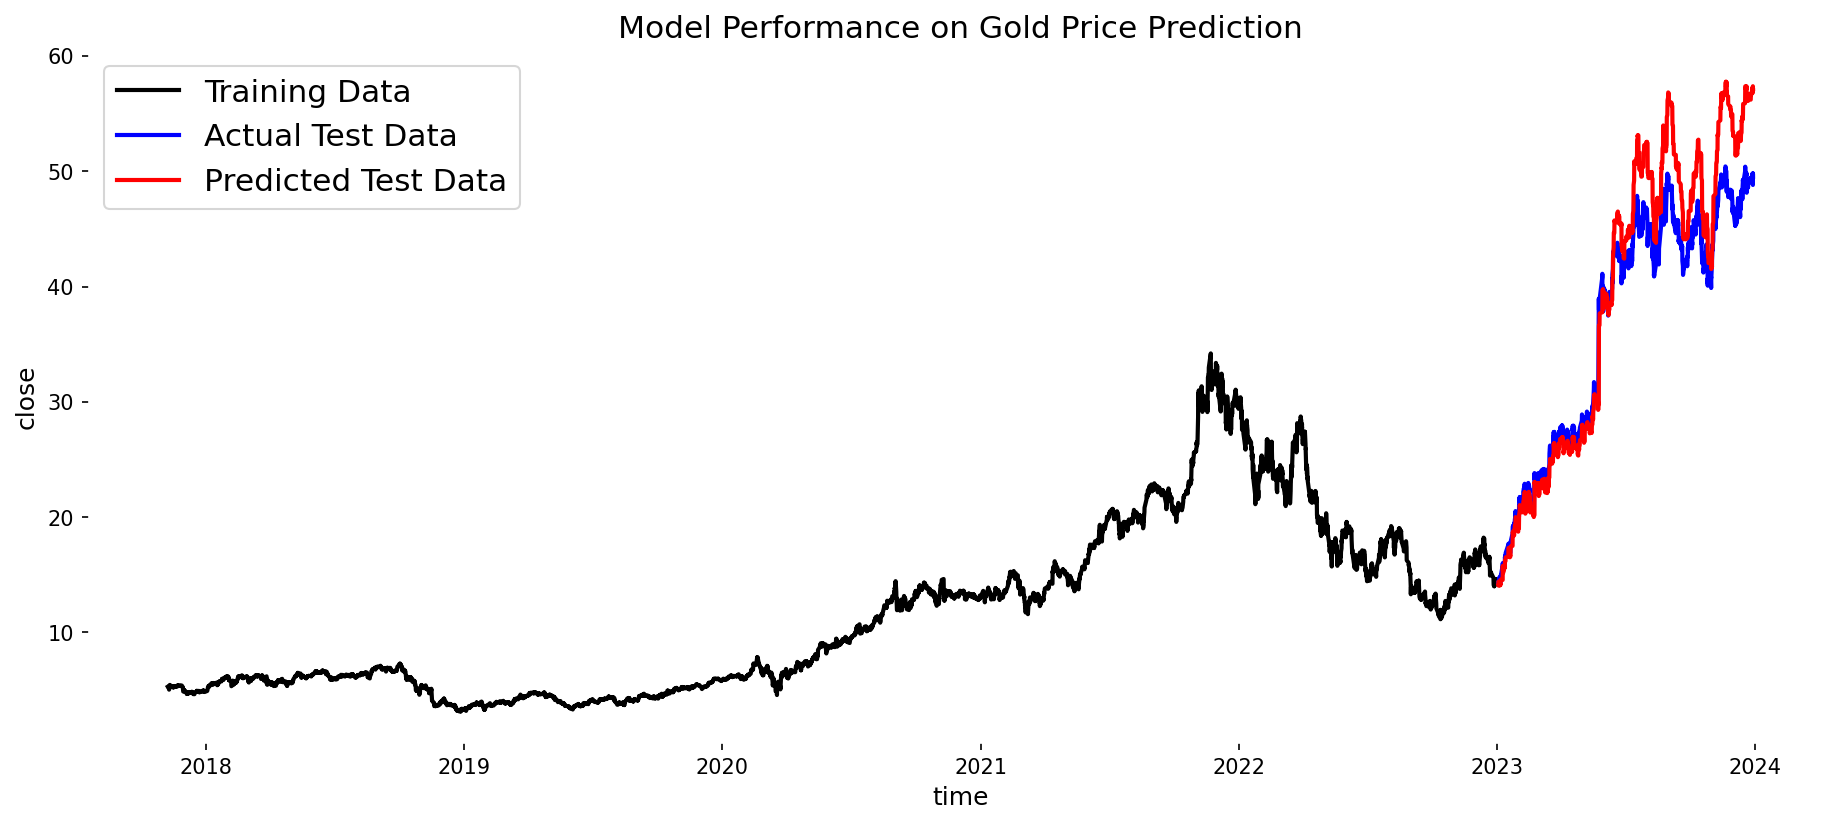

In [68]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams["axes.facecolor"] = "White"
plt.rc("axes", edgecolor="white")
plt.plot(
    df["time"].iloc[:-test_size],
    scaler.inverse_transform(train_data),
    color="black",
    lw=2,
)
plt.plot(df["time"].iloc[-test_size:], y_test_true, color="blue", lw=2)
plt.plot(df["time"].iloc[-test_size:], y_test_pred, color="red", lw=2)
plt.title("Model Performance on Gold Price Prediction", fontsize=15)
plt.xlabel("time", fontsize=12)
plt.ylabel("close", fontsize=12)
plt.legend(
    ["Training Data", "Actual Test Data", "Predicted Test Data"],
    loc="upper left",
    prop={"size": 15},
)
plt.grid(color="white")
plt.show()

We can see that there is a 0.0049 percent of log where the accuracy is 92411 percent 